# CASAS twor.2009 Dataset

Cook, D., Schmitter-Edgecombe, M., Crandall, A., Sanders, C., & Thomas, B. (2009, April). Collecting and disseminating smart home sensor data in the CASAS project. In Proceedings of the CHI workshop on developing shared home behavior datasets to advance HCI and ubiquitous computing research (pp. 1-7).


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
fileName = "annotated"
dataDir = '../Dataset/twor.2009/'
columns = ["Date", "Time", "SensorID", "SensorValue", "ActivityLabel", "Status"]
raw = pd.read_csv(dataDir+fileName, sep=" ", names=columns, header=None)

In [3]:
raw.head()

,Date,Time,SensorID,SensorValue,ActivityLabel,Status
0,2009-02-06,17:15:22.42803,M41,ON,R2_work_at_computer,begin
1,2009-02-06,17:15:27.645659,M41,OFF,NaN,NaN
2,2009-02-06,17:15:30.88262,M40,OFF,NaN,NaN
3,2009-02-06,17:15:44.132329,M46,ON,NaN,NaN
4,2009-02-06,17:15:51.52937,M46,ON,NaN,NaN


In [4]:
activity_labels = raw["ActivityLabel"].unique()
notna = [type(l)==type("") for l in activity_labels]
activity_labels = activity_labels[notna]
activity_labels

array(['R2_work_at_computer', 'R1_sleep', 'R2_sleep', 'R1_bed_to_toilet',
       'R2_bed_to_toilet', 'R1_groom', 'R2_groom', 'R1_breakfast',
       'R2_breakfast', 'R1_work_at_computer', 'R2_prepare_dinner',
       'R2_prepare_lunch', 'Cleaning', 'R1_work_at_dining_room_table',
       'R2_watch_TV', 'Wash_bathtub'], dtype=object)

In [5]:
classmap = {k:i for i,k in enumerate(activity_labels)}

In [6]:
sensors = np.sort(raw["SensorID"].unique())
sensormap = {k:i for i, k in enumerate(sensors)}

In [7]:
analog_sensors = ["AD1-A", "AD1-B", "AD1-C"]
for s in analog_sensors:
    d = raw[raw["SensorID"]==s]
    d["SensorValue"] = d["SensorValue"].astype(float)
    
    print("Sensor: ", s)
    mx = d["SensorValue"].max()
    mn = d["SensorValue"].min()
    print("Max", mn, "Min", mx)
    def normalise(x):
        if x["SensorID"]==s:
            try:
                return (float(x["SensorValue"]) - mn)*1.0/(mx - mn)
            except Exception as e:
                print(e)
                print(type(mn), type(mx), type(float(x["SensorValue"])))
                print("ERROR", x["SensorValue"])
                return 0
        else:
            return x["SensorValue"]
        
    raw["NormSensorValue"] = raw.apply(normalise, axis=1)
    

Sensor:  AD1-A
Max 2.77903 Min 3.36552
Sensor:  AD1-B
Max 0.0290629 Min 0.573173
Sensor:  AD1-C
Max 0.0293364 Min 0.572626


In [8]:
raw["SensorValue"] = raw["NormSensorValue"]

In [9]:
# Add time stamp to data
data = raw
# data = raw[(raw["ActivityLabel"].notna()) | (raw["SensorValue"] != "OFF")]
data['DateTime'] =  data['Date'] + " "+data['Time']
data['Timestamp'] =  pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S.%f')

In [10]:
def transform(d):
    g = []
    activity = None
    currGroup = []
    d["na"] = d[["ActivityLabel"]].isna()
    
    for i, row in d.iterrows():
        if not row["na"]:
            currGroup.append(row)
            activity = row["ActivityLabel"]
            if row['Status'] == "end":
                g.append(currGroup)
                currGroup = []
        else:
            row["ActivityLabel"] = activity
            row["Status"] = "working"
            currGroup.append(row)
            
    g.append(currGroup)
    return g

grouped = transform(data)

In [11]:
# _ = transform(data)
df_grouped = []
for g in grouped:
    df = pd.DataFrame(g)
    df_grouped.append(df)


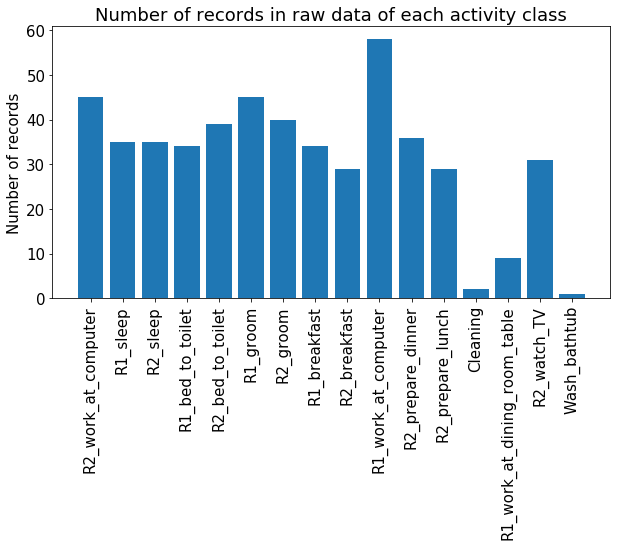

In [12]:
nRow = [0 for a in activity_labels]
nEventPerClass = {k:[] for k in activity_labels}

for g in df_grouped:
    if len(g) <=0:
        continue
        
    label = g.head(1)["ActivityLabel"].values[0]
    index = classmap[label]
    nRow[index] += 1
    nEventPerClass[label].append(len(g))

ind = np.arange(len(activity_labels))
plt.rcParams['figure.figsize'] = [10, 5]

plt.rcParams.update({'font.size': 15})
p1 = plt.bar(ind, nRow)

plt.ylabel('Number of records')
plt.title('Number of records in raw data of each activity class')
plt.xticks(ind, activity_labels, rotation='vertical')

plt.show()

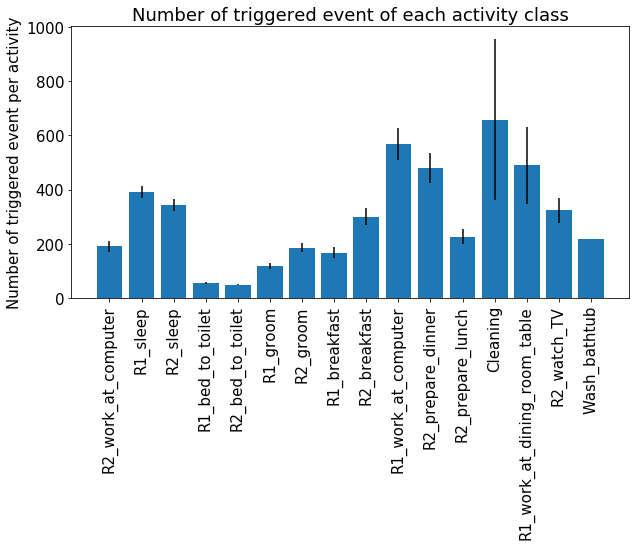

In [13]:
from scipy import stats

nEvent = [np.mean(nEventPerClass[k]) for k in nEventPerClass]
nEventStd = [stats.sem(nEventPerClass[k], axis=None, ddof=0) for k in nEventPerClass]

ind = np.arange(len(activity_labels))
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 15})
p1 = plt.bar(ind, nEvent, yerr=nEventStd)

plt.ylabel('Number of triggered event per activity')
plt.title('Number of triggered event of each activity class')
plt.xticks(ind, activity_labels, rotation='vertical')

plt.show()


In [14]:
def sensorvalue(row):
    sensorId = row["SensorID"]
    if row["SensorValue"] in ["O", "ON", "ONF", "OPEN", "PRESENT"]:
        return (sensorId, 1)
    elif row["SensorValue"] in ["OFFF","OF", "OFF", "CLOSE", "ABSENT"]:
        return (sensorId, 0)
    else:
        if sensorId not in analog_sensors:
            print(sensorId)
        # check isnumber https://stackoverflow.com/questions/354038/how-do-i-check-if-a-string-is-a-number-float
        value = str(row["SensorValue"])
        isNumberic = value.replace('.','',1).isdigit()
        if isNumberic:
            value = float(value)
            return (sensorId, value)
        else:
            raise Exception('Unknown keyword: '+row["SensorValue"])
            
def toTimeSeries(df, width):

    rows = []
    start = df["Timestamp"].iloc[0].timestamp()
    timestamp = start
    activityLabel = df["ActivityLabel"].iloc[0]
    
    eventsinwindow = {}
    for i, row in df.iterrows():
        t = row["Timestamp"].timestamp()
        interval = ((t-start)//width)
        
        if interval in eventsinwindow:
            eventsinwindow[interval].append(sensorvalue(row))
        else:
            eventsinwindow[interval] = [sensorvalue(row)]
            
    
    timeslot = eventsinwindow.keys()
    timerange = range(int(min(timeslot)), int(max(timeslot))+1)
    sensor_values = []

    for s in sensors:
        values = [0 for t in timerange]
        
        for t in timerange:
            if t not in eventsinwindow:
                continue
                
            events = eventsinwindow[t]
            for sensorId, value in events:
                ind = sensormap[sensorId]
                if sensorId == s:
                    values[t] += value
                    
        sensor_values.append(values)
    return sensor_values, timestamp
    



In [15]:
# def plotTimeSeries(ts):
    
#     if len(ts) <=0:
#         return
    
#     t0 = ts[0]
#     ind = np.arange(len(t0))
    
#     for t in ts:
#         p1 = plt.bar(ind, t)

#     plt.ylabel('Triggered event value')
#     plt.xlabel('Time(mins)')
#     plt.title('Triggered event value by time')
#     plt.xticks(ind, [i*SLOT_WIDTH//60 for i in ind])
    
#     plt.show()

# plt.rcParams['figure.figsize'] = [15, 2]
# # slide long activity in to many slots
# SLOT_WIDTH = 15*60

# target = df_grouped[2]
# ts = toTimeSeries(target, SLOT_WIDTH)
# print("Label", target["ActivityLabel"].iloc[0])
# plotTimeSeries(ts)

In [16]:
df_by_labels = {a:[] for a in activity_labels}

    
for d in df_grouped:
    if len(d) <=0:
        continue
    label = d["ActivityLabel"].iloc[0]
    df_by_labels[label].append(d)


In [17]:


def plotHeatMap(ax, ts, label):
    ax.set_ylabel('Sensor ID')
    ax.set_xlabel('Time(mins)')
    ax.set_title('Triggered event value by time ['+label+"]")
    ax.imshow(ts, cmap='Greys')
    
def normalise(ts):
    if len(ts) <=0:
        return ts
    
    acc = [0 for v in ts[0]]
    
    for t in ts:
        ind = 0
        for v in t:
            acc[ind] += v
            ind += 1
    
    for t in ts:
        ind = 0
        for a in acc:
            if t[ind] ==0:
                continue
            t[ind] = t[ind]*1.0/a
            ind += 1
    return ts

# for a in activity_labels:
#     target = df_by_labels[a][0]
    
#     ts = toTimeSeries(target, 60)
#     ts = normalise(ts)
#     plotHeatMap(ts, a)

# target = df_by_labels["R2_bed_to_toilet"][4]
# ts = toTimeSeries(target, 10)
# ts = normalise(ts)
# plotHeatMap(ts, "R2_bed_to_toilet")


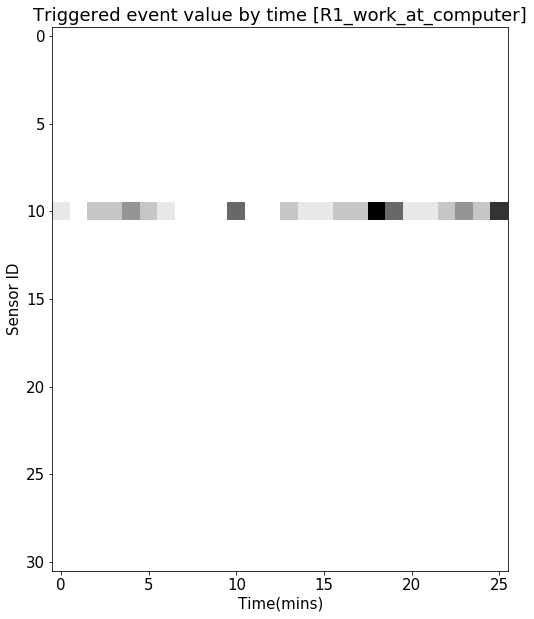

In [18]:

plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1, 1) 
target = df_by_labels["R1_work_at_computer"][0]
ts, _ = toTimeSeries(target.head(100), 60)
ts = normalise(ts)
ts = ts[40:]
plotHeatMap(ax, ts, "R1_work_at_computer")


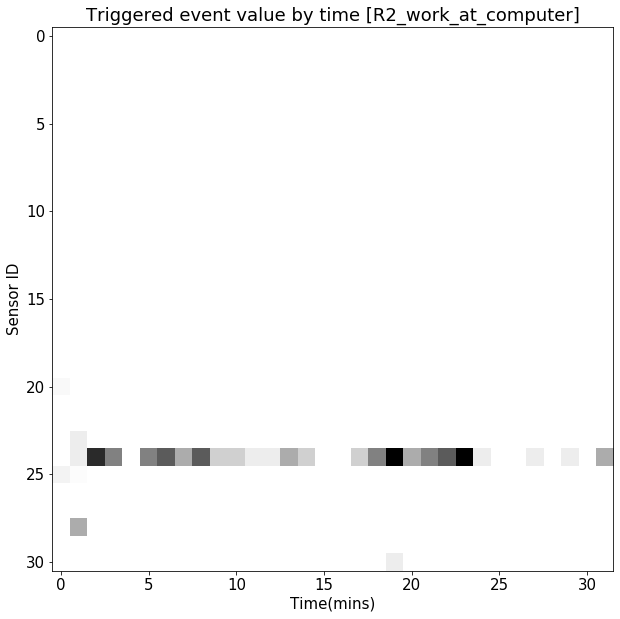

In [19]:

fig, ax = plt.subplots(1, 1) 
target = df_by_labels["R2_work_at_computer"][0]
ts, _ = toTimeSeries(target, 60)
ts = normalise(ts)
ts = ts[40:]
plotHeatMap(ax, ts, "R2_work_at_computer")



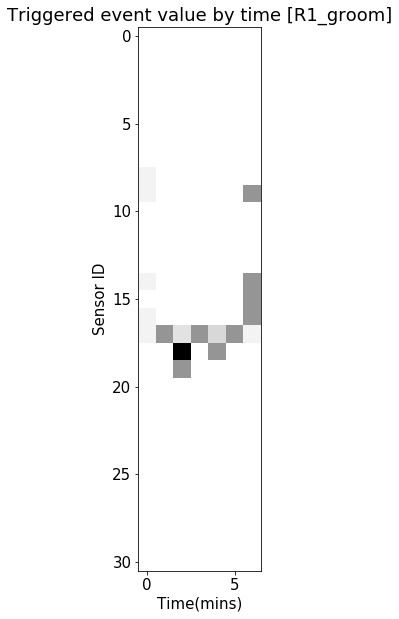

In [20]:

fig, ax = plt.subplots(1, 1)
                               
target = df_by_labels["R1_groom"][3]
ts, _ = toTimeSeries(target, 60)
ts = normalise(ts)
ts = ts[40:]
plotHeatMap(ax, ts, "R1_groom")

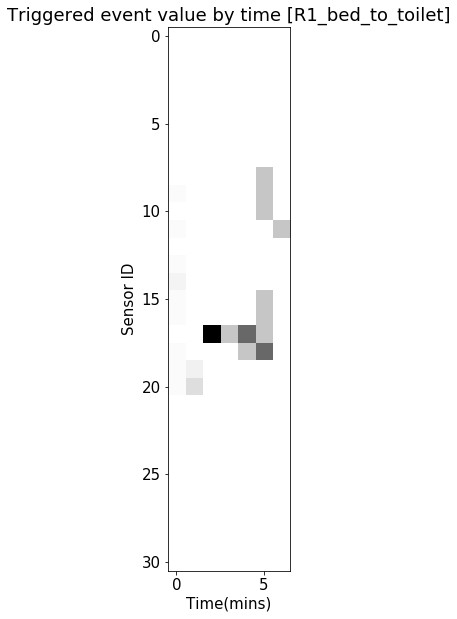

In [21]:
fig, ax = plt.subplots(1, 1)
target = df_by_labels["R1_bed_to_toilet"][3]
ts, _ = toTimeSeries(target, 60)
ts = normalise(ts)
ts = ts[40:]
plotHeatMap(ax, ts, "R1_bed_to_toilet")


In [22]:
def to_vector_sliding_window(ts, label, window_size=2, timestamp=None, normalise=True):
    t0 = ts[0]
    T = len(t0)
    vectors = []
    for i in range(T):
        if i+window_size > T:
            break
        
        vector = [0 for s in sensors]
        for j in range(window_size):
            tid = i+j
            
            for sid in range(len(ts)):
                vector[sid] += ts[sid][tid]*1.0
            
        if normalise:
            acc = sum(vector)
            if acc == 0:
                continue
            vector = [v*1.0/acc for v in vector]
        
        vector.append(label)
        vectors.append(vector)
    return vectors

def to_vector_chunk(ts, label, chunk_size = 15, timestamp=None, normalise=True):
    t0 = ts[0]
    T = len(t0)
    vectors = []
    chunk_index = range(0, len(t0), chunk_size)
    for i in chunk_index:
        
        vector = [0 for s in sensors]
        for j in range(i, i+chunk_size):
            if j >= len(t0):
                break
                
            tid = j
            for sid in range(len(ts)):
                vector[sid] += ts[sid][tid]*1.0
                
        acc = sum(vector)
        if acc == 0:
            continue 
            
        if normalise:
            vector = [v*1.0/acc for v in vector]
        
        vector.append(label)
        vectors.append(vector)
    return vectors


cols = list(sensors)
cols.append("ActivityLabel")
vectors = pd.DataFrame(columns=cols)

for d in df_grouped:
    if len(d) <=0:
        continue
        
    label = d["ActivityLabel"].iloc[0]
    ts, timestamp = toTimeSeries(d, 60)
    window_size = 5
    
    if len(ts[0]) < 5:
        window_size = len(ts[0])
        
    v = to_vector_chunk(ts, label, chunk_size=1, timestamp=timestamp, normalise=True)  
#     v = to_vector_with_windows(ts, label, window_size=window_size, timestamp=timestamp, normalise=True)
    
    v = pd.DataFrame(v, columns=cols)
    vectors = vectors.append(v, ignore_index=True)
    

print("length:", len(vectors))
vectors.head()






length: 17870


,AD1-A,AD1-B,AD1-C,D03,D05,D07,D08,D09,D10,D12,...,M43,M44,M45,M46,M47,M48,M49,M50,M51,ActivityLabel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.666667,0.0,0.0,0.0,0.0,0.0,R2_work_at_computer
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.166667,0.166667,0.166667,0.0,0.0,0.5,0.0,0.0,R2_work_at_computer
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,R2_work_at_computer
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,R2_work_at_computer
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,R2_work_at_computer


['R2_work_at_computer' 'R1_sleep' 'R2_sleep' 'R1_bed_to_toilet'
 'R2_bed_to_toilet' 'R1_groom' 'R2_groom' 'R1_breakfast' 'R2_breakfast'
 'R1_work_at_computer' 'R2_prepare_dinner' 'R2_prepare_lunch' 'Cleaning'
 'R1_work_at_dining_room_table' 'R2_watch_TV' 'Wash_bathtub']


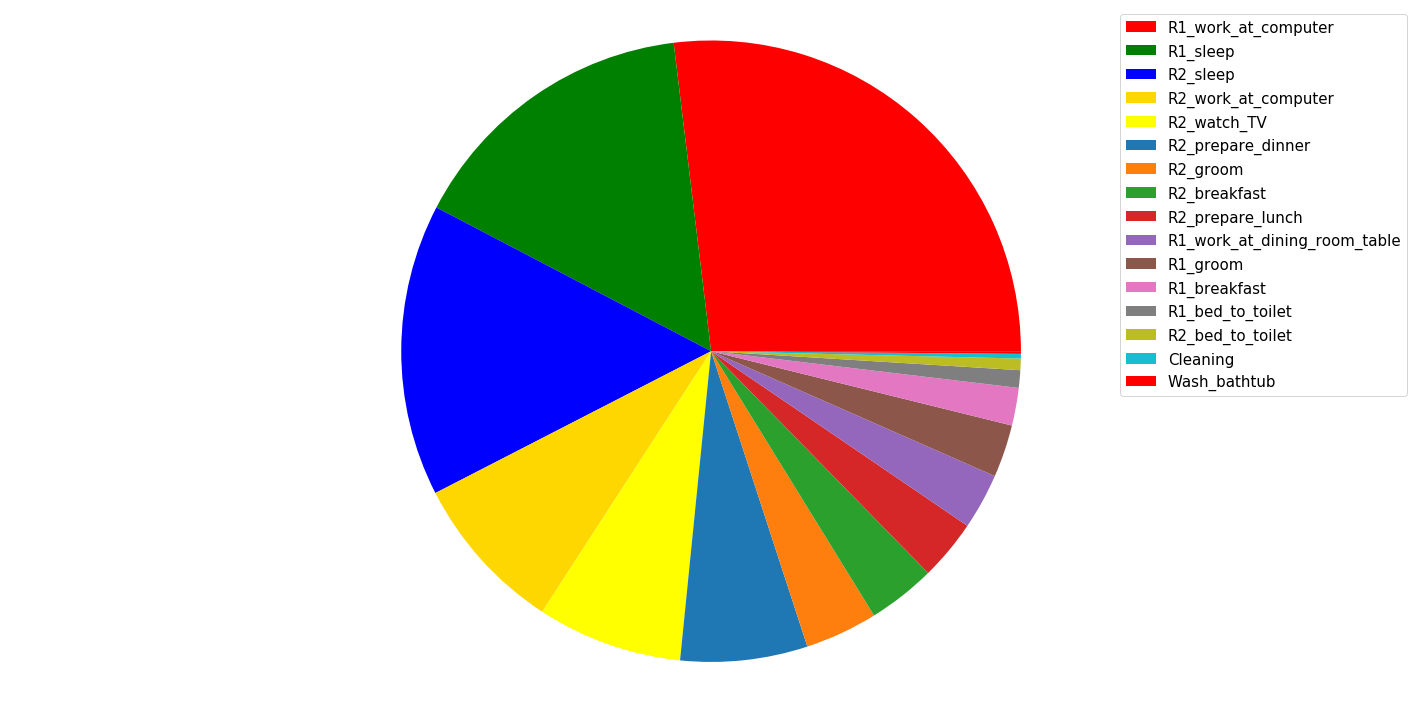

In [23]:
from functools import cmp_to_key

from matplotlib import colors as mcolors
colors = ["red", "green", "blue", "gold", "yellow"] + list(mcolors.TABLEAU_COLORS.values()) 

p = vectors["ActivityLabel"]
v = vectors[["ActivityLabel"]]
v["c"] = 1

labels = p.unique()
count = v.groupby(['ActivityLabel']).agg(['count'])[("c", "count")]
labels, count

def compare(item1, item2):
    return count[item2] - count[item1]

print(labels)
labels = sorted(labels, key=cmp_to_key(compare))
sizes = [count[l] for l in labels]

fig1, ax1 = plt.subplots()
patches, texts = ax1.pie(sizes, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(patches, labels, loc="best")
plt.tight_layout()
plt.show()

In [24]:
vectors.to_csv(dataDir+fileName+".feat.ch1", index=False)

In [29]:
def plotHeatMapv2(ax, ts, label, cmap="Blues"):
    lst = []
    for t in ts:
        lst.append(t[0])
    while len(lst) % 10 > 0:
        lst.append(0)
    o = [lst[6*i: 6*i+6] for i in range(6)]
#     print(o)
#     ax.axis('off')
    ax.imshow(o, cmap=cmap)

['R2_work_at_computer', 'R1_sleep', 'R2_sleep', 'R1_bed_to_toilet', 'R2_bed_to_toilet', 'R1_groom', 'R2_groom', 'R1_breakfast', 'R2_breakfast', 'R1_work_at_computer', 'R2_prepare_dinner', 'R2_prepare_lunch', 'Cleaning', 'R1_work_at_dining_room_table', 'R2_watch_TV', 'Wash_bathtub']


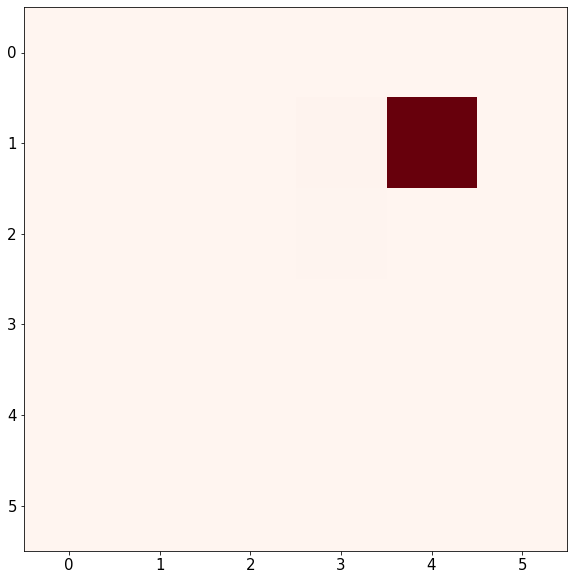

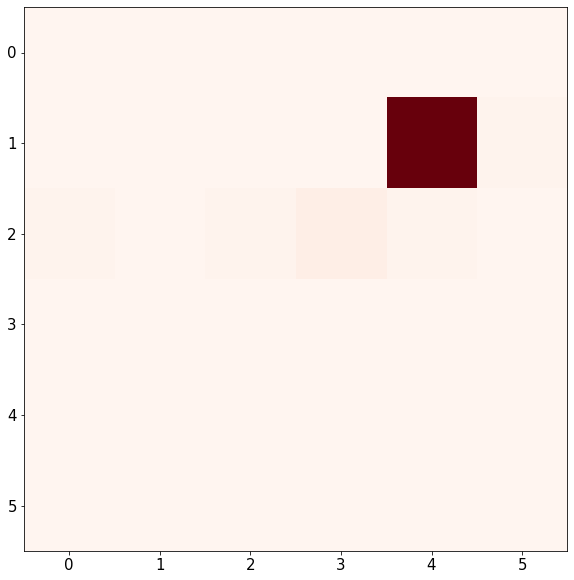

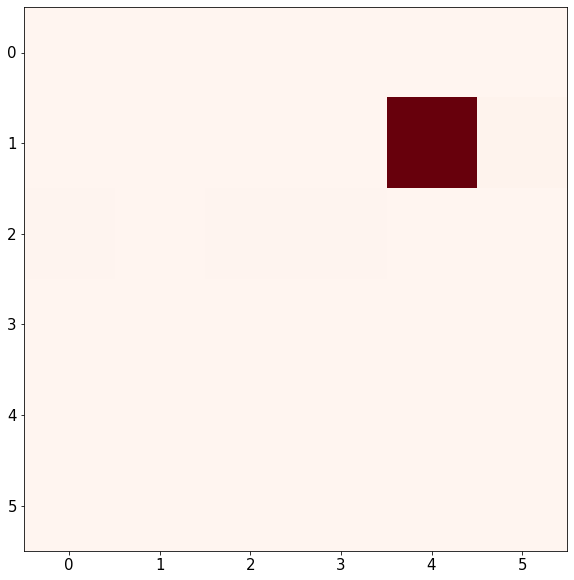

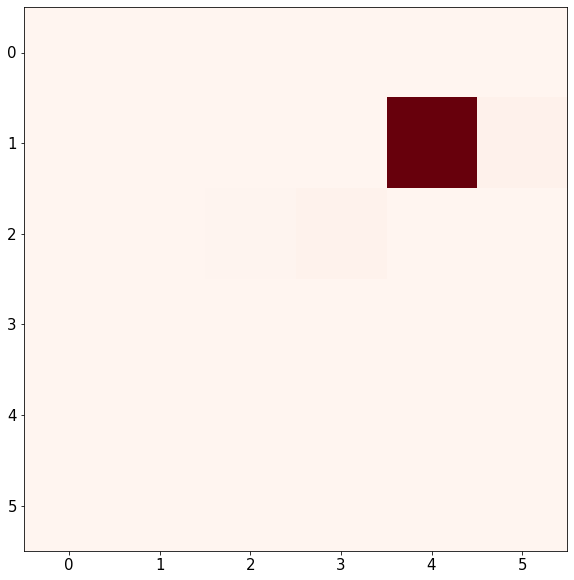

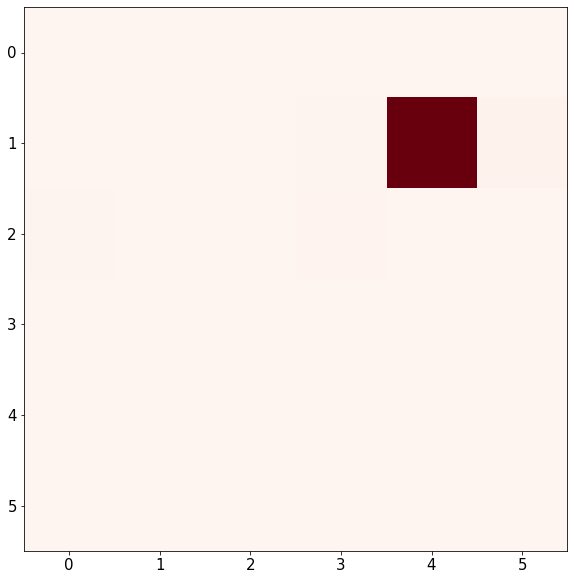

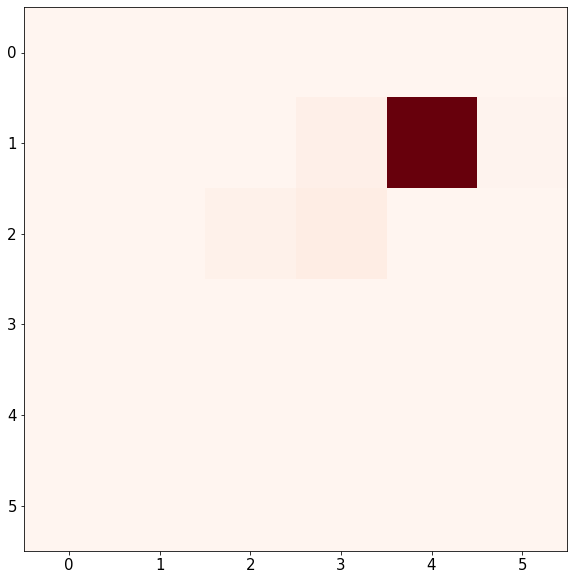

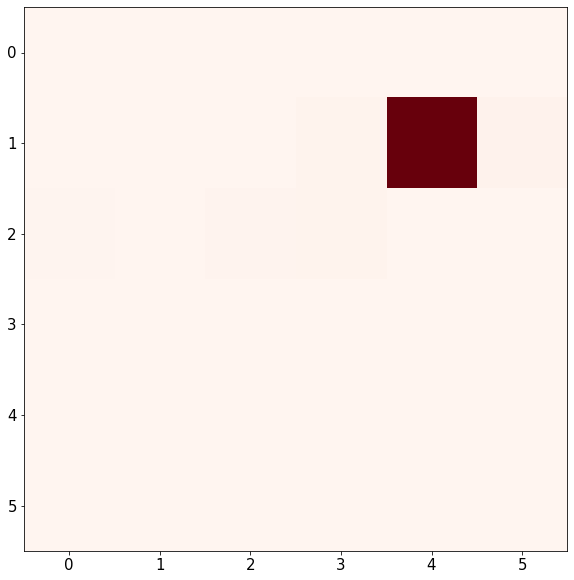

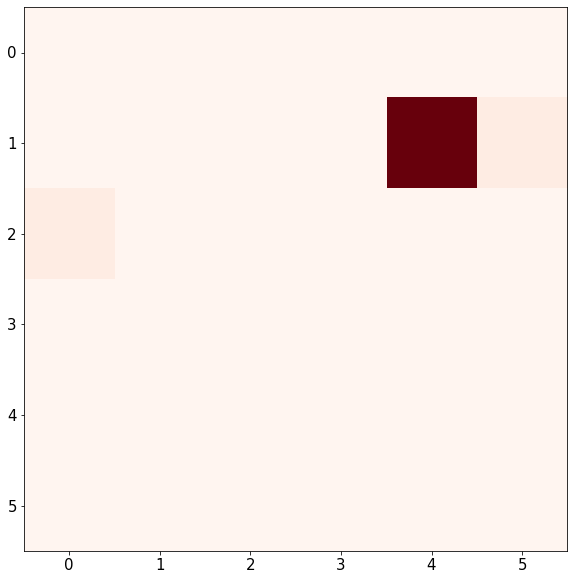

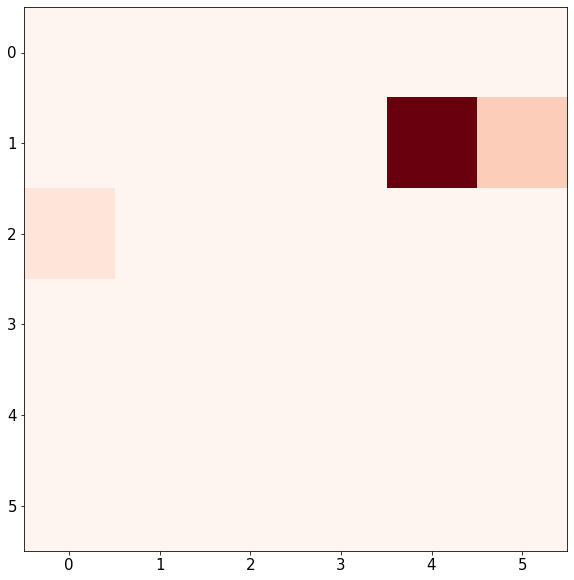

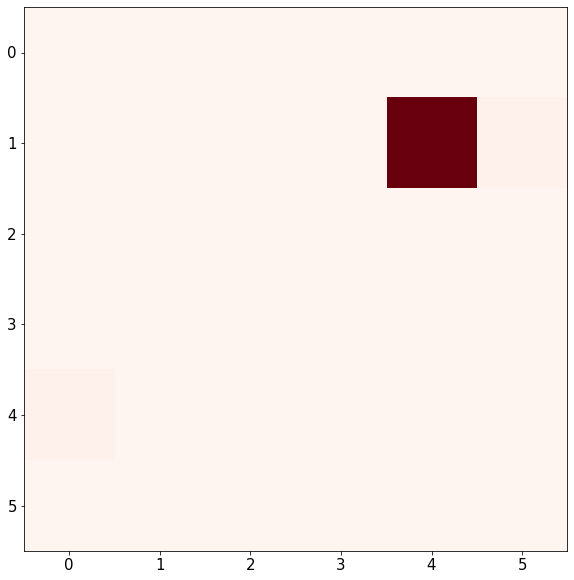

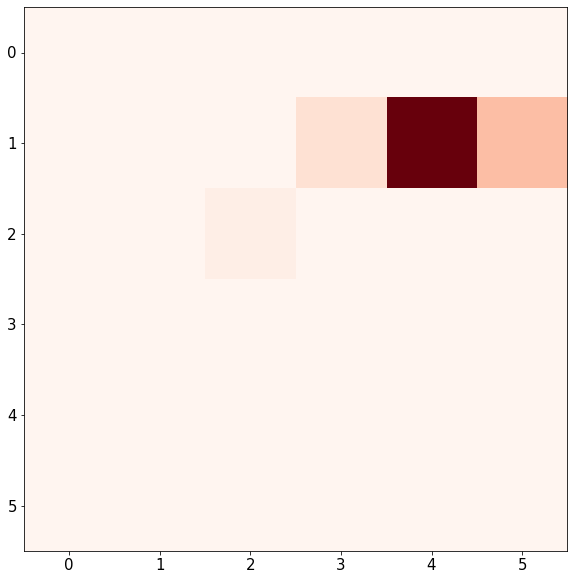

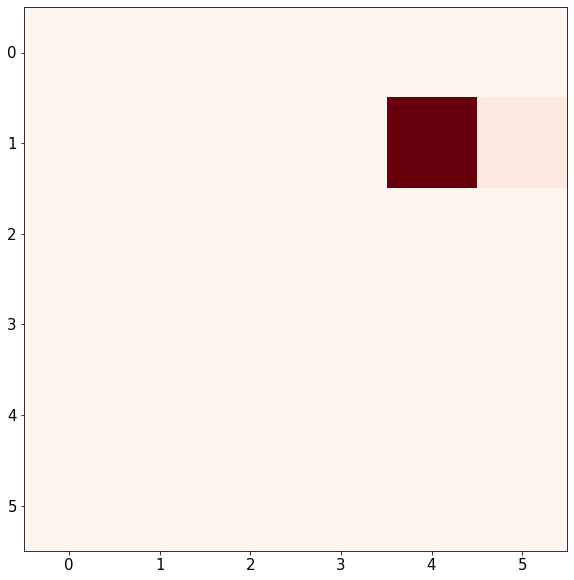

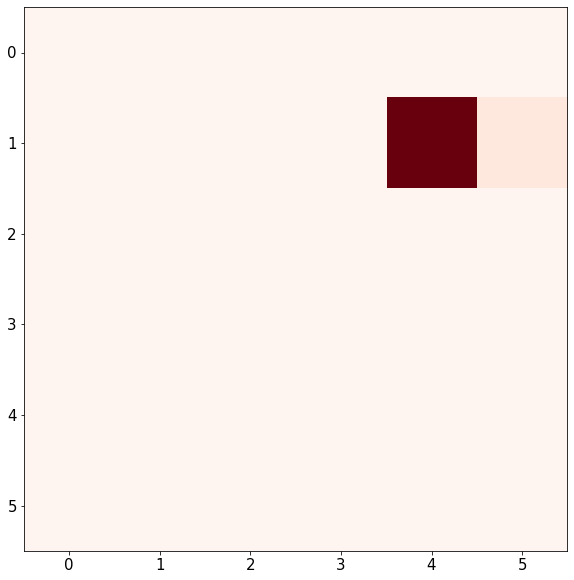

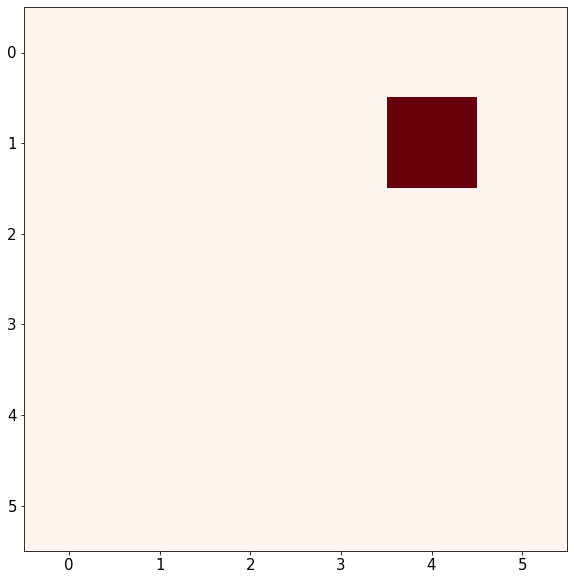

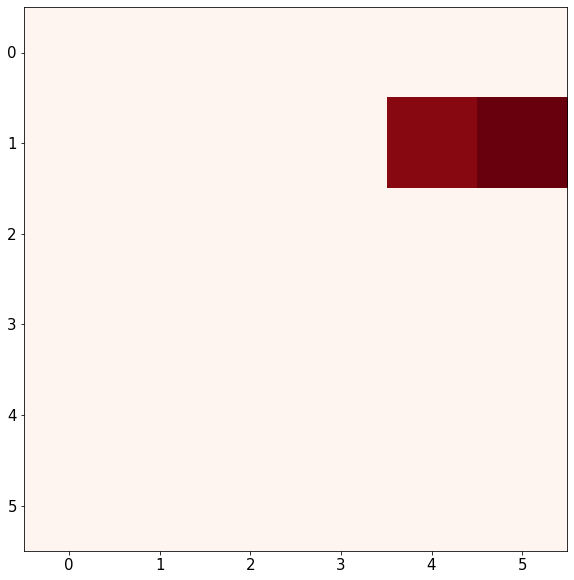

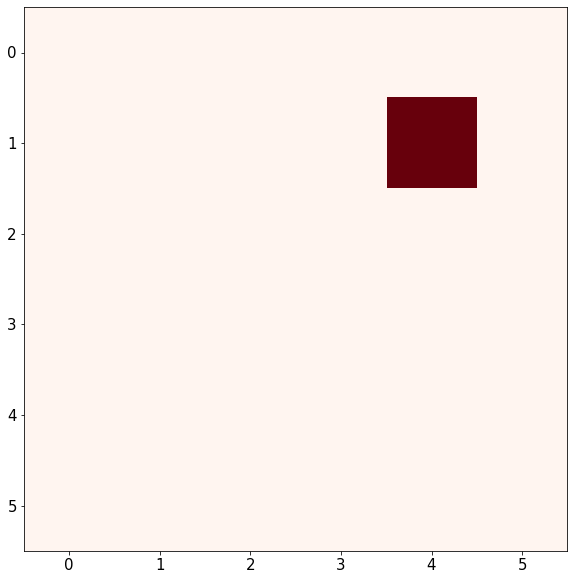

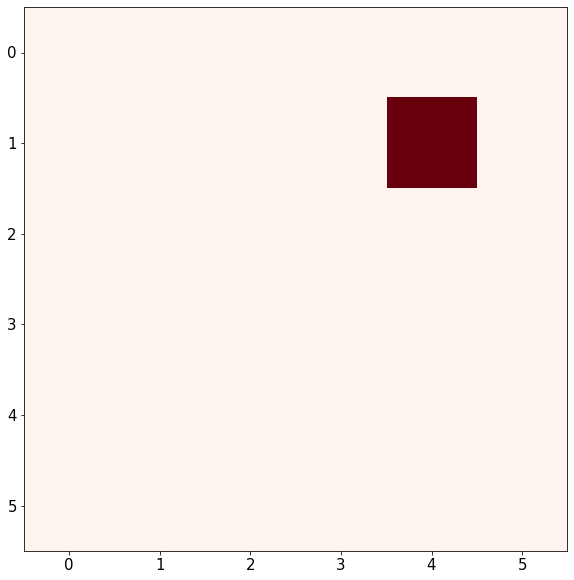

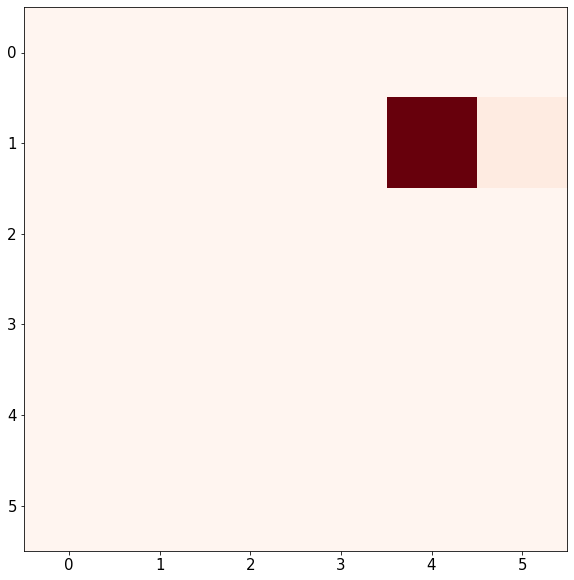

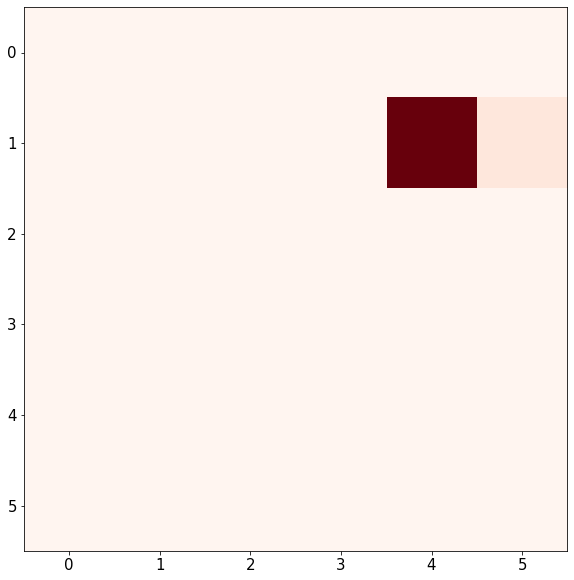

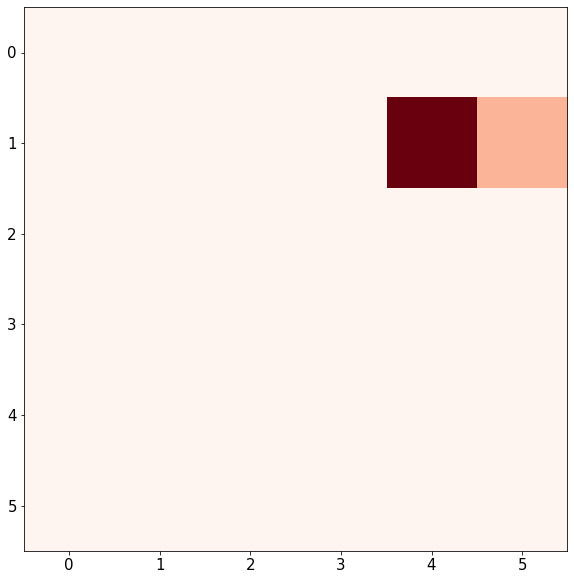

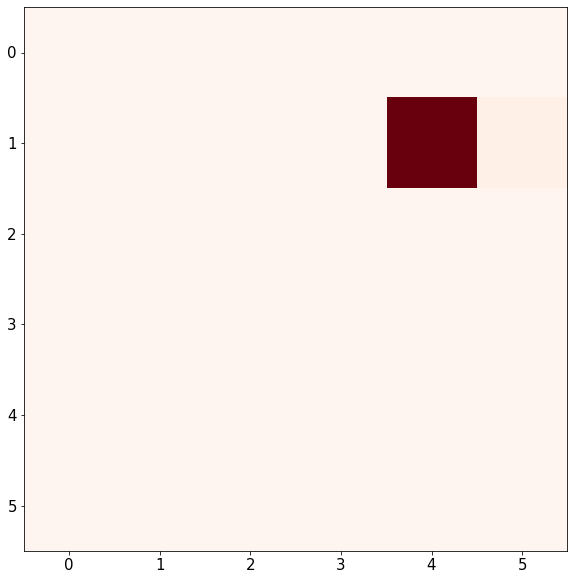

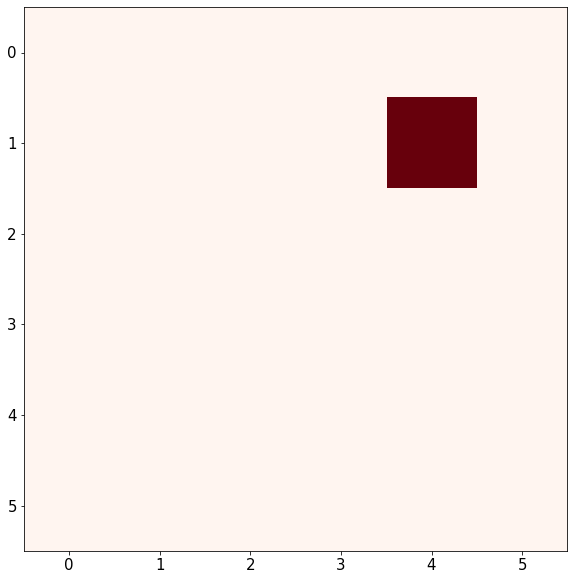

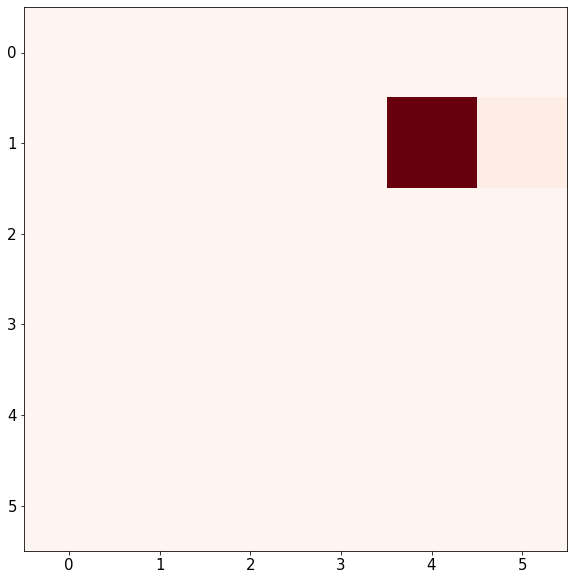

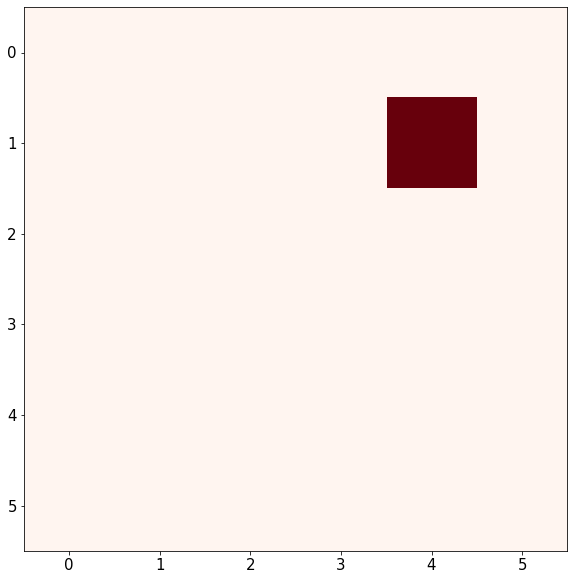

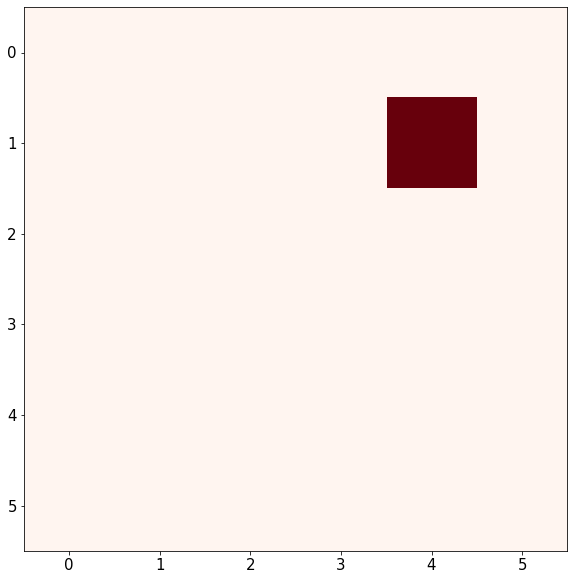

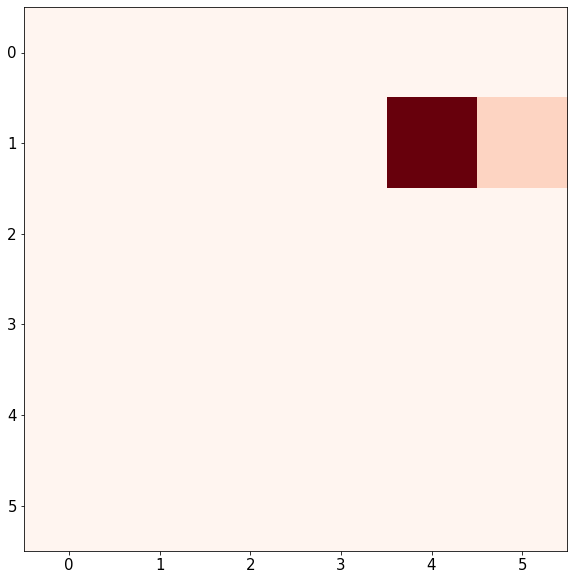

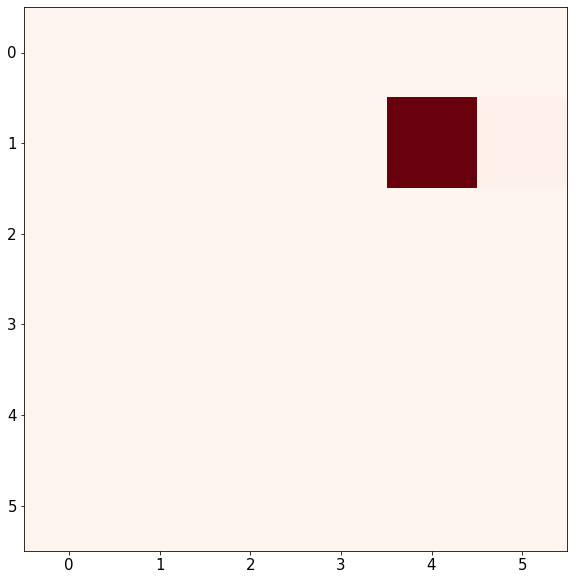

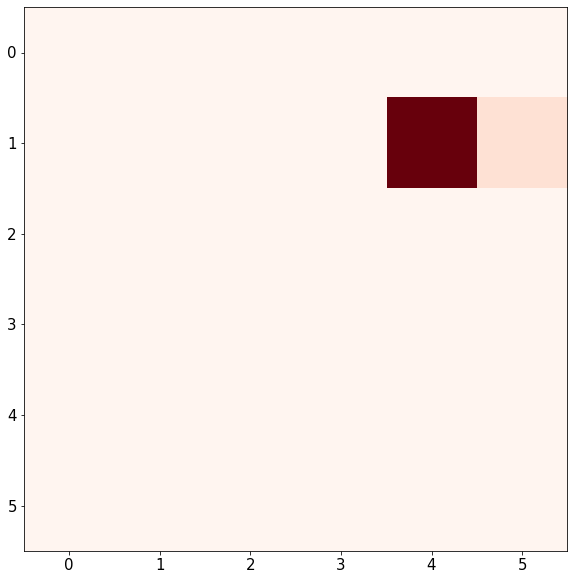

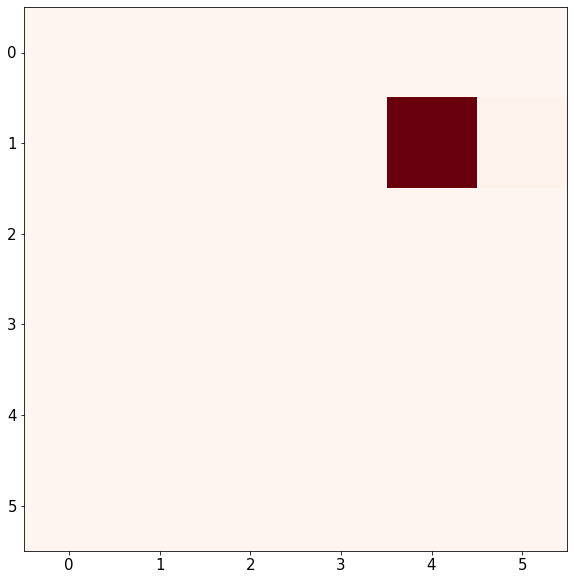

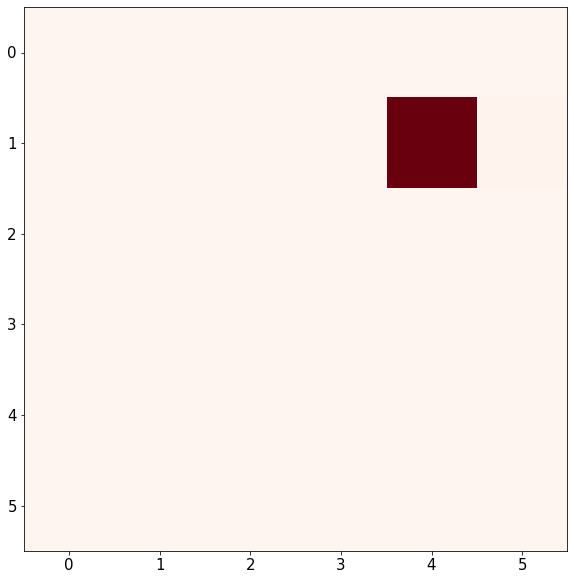

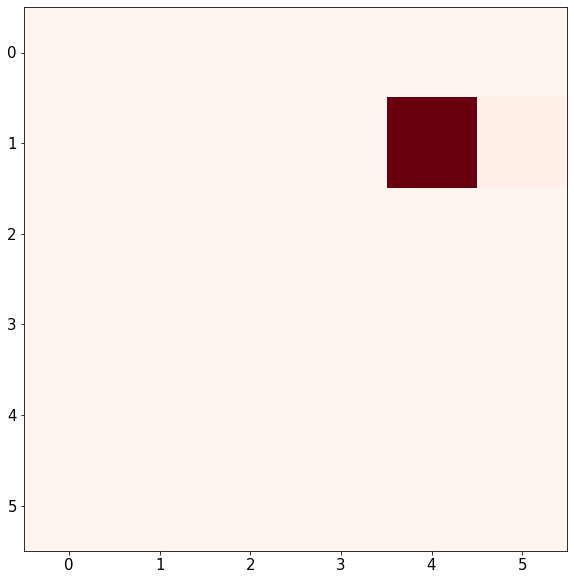

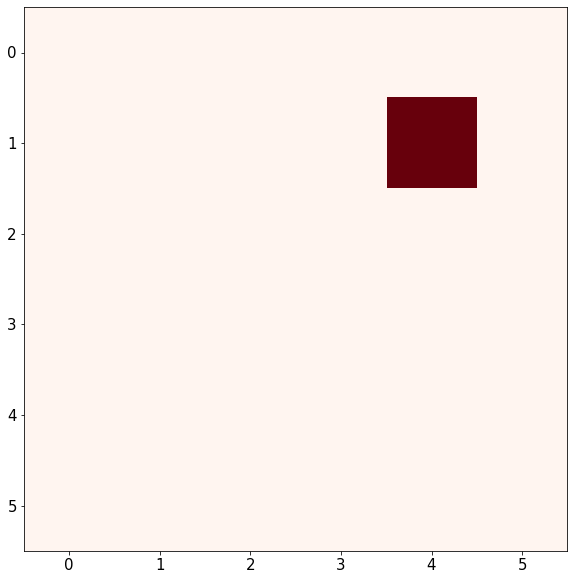

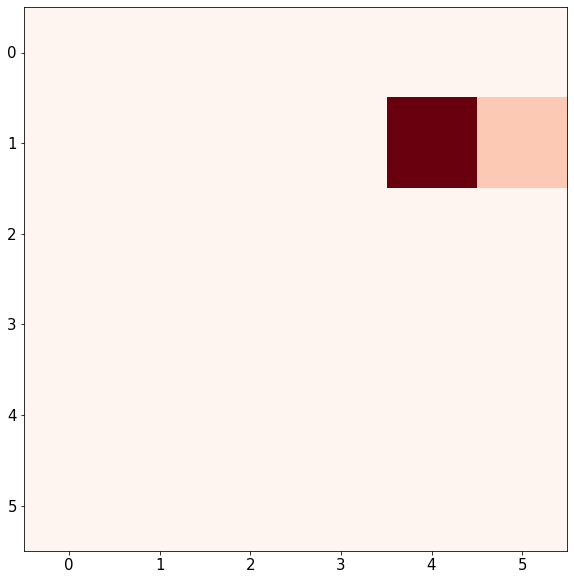

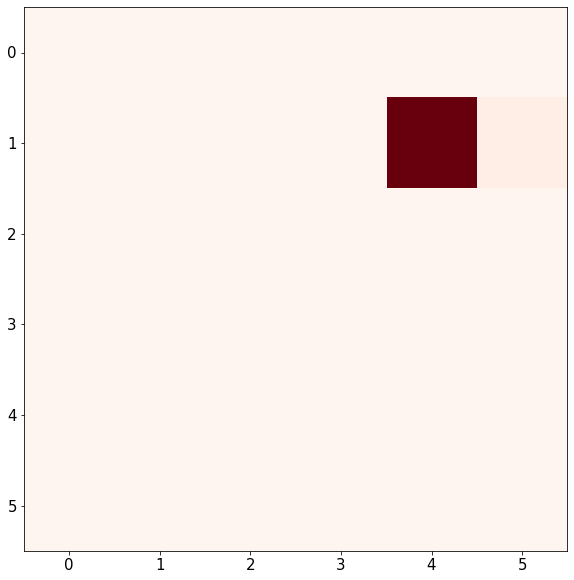

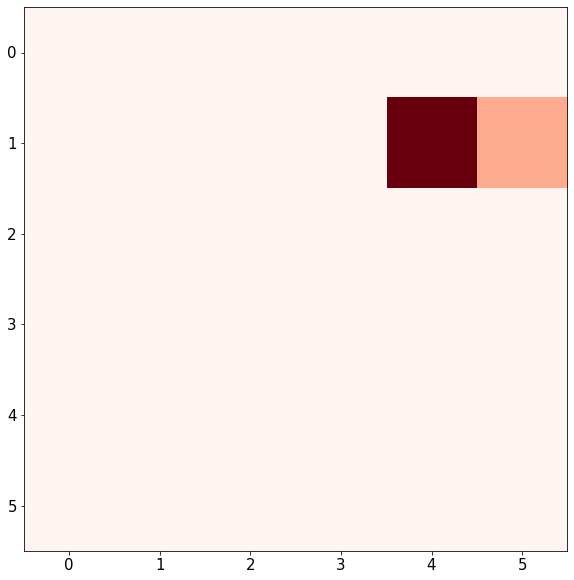

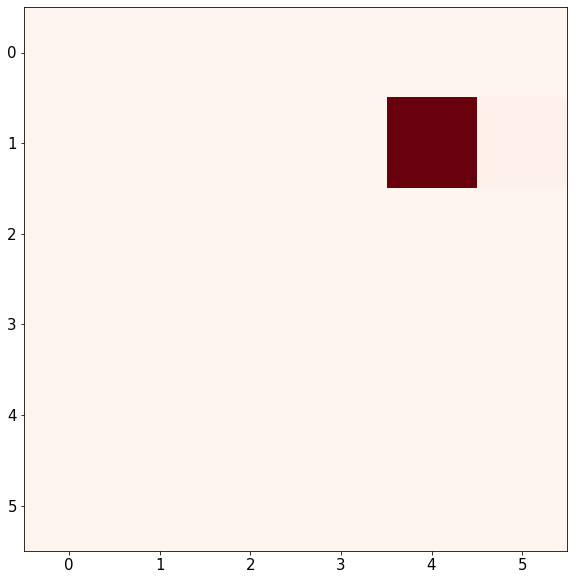

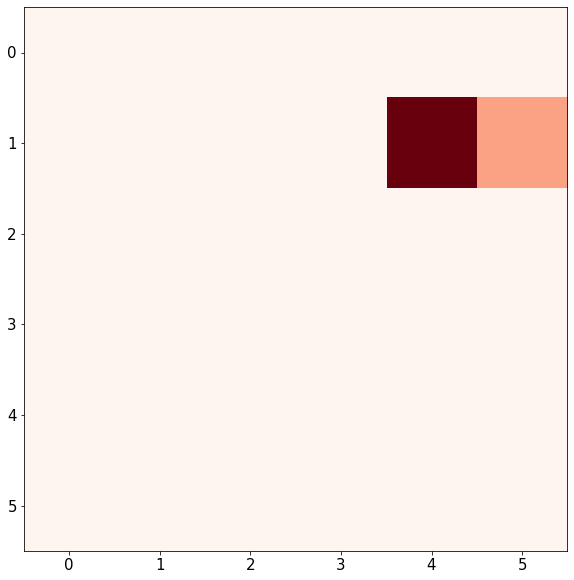

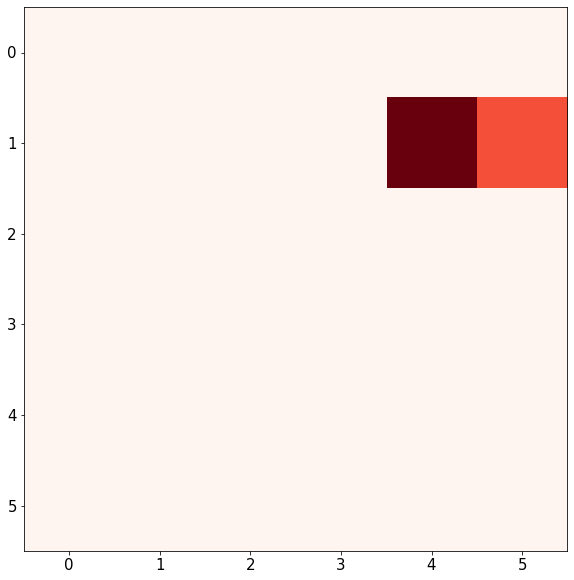

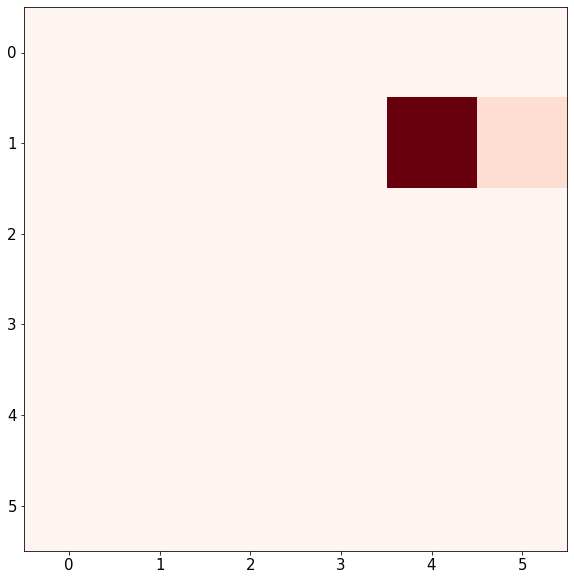

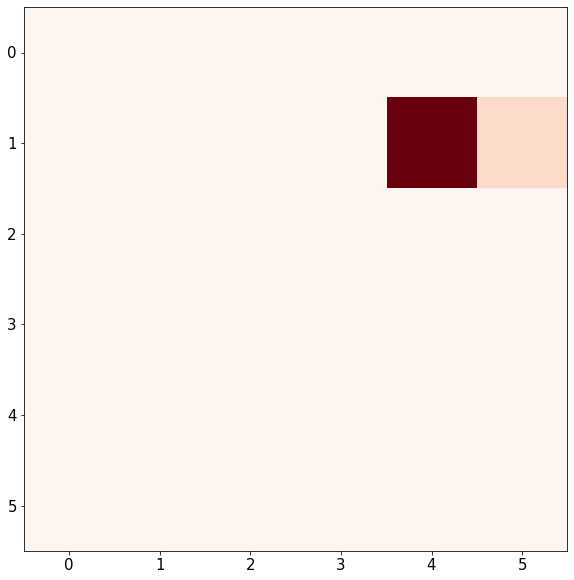

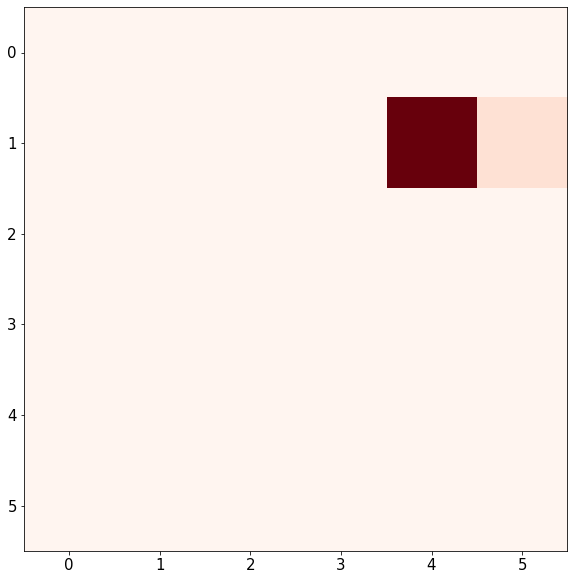

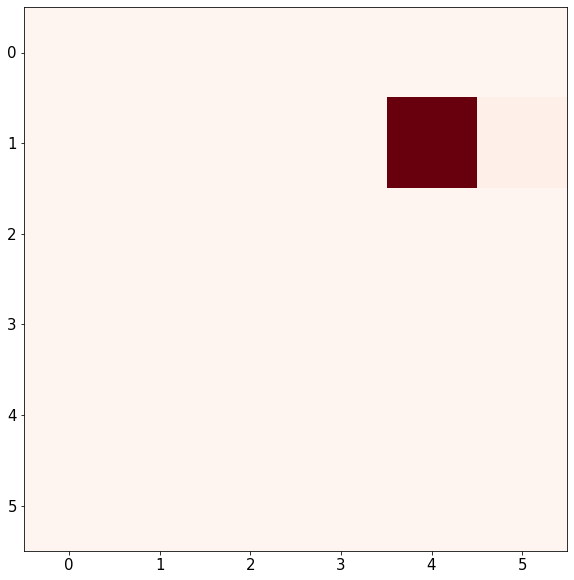

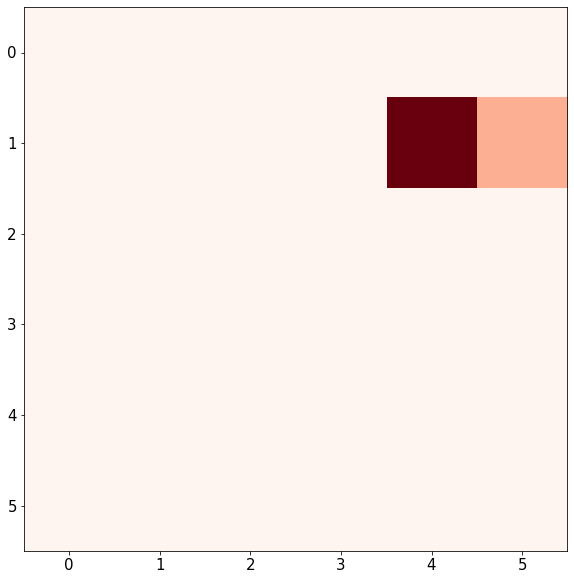

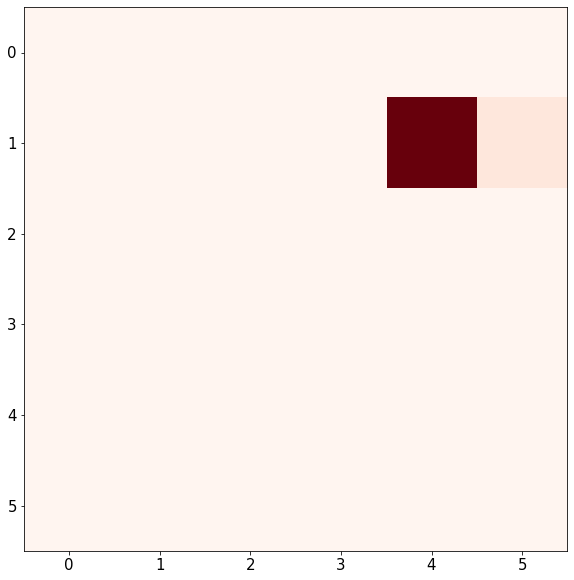

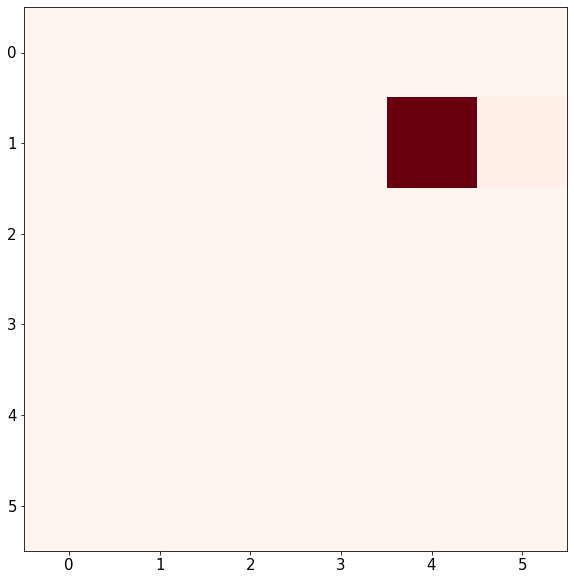

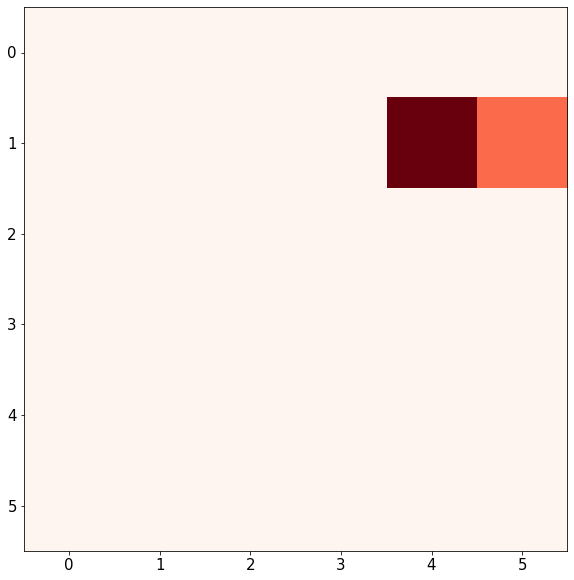

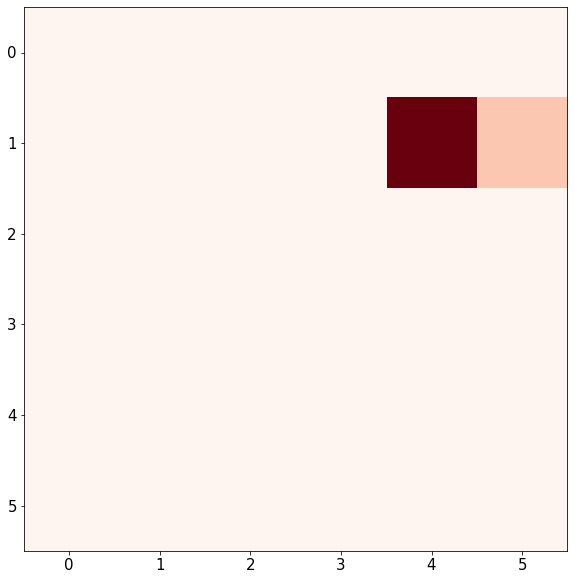

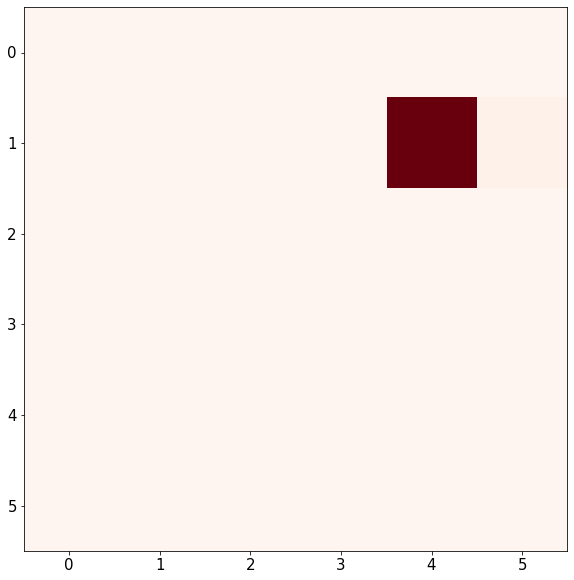

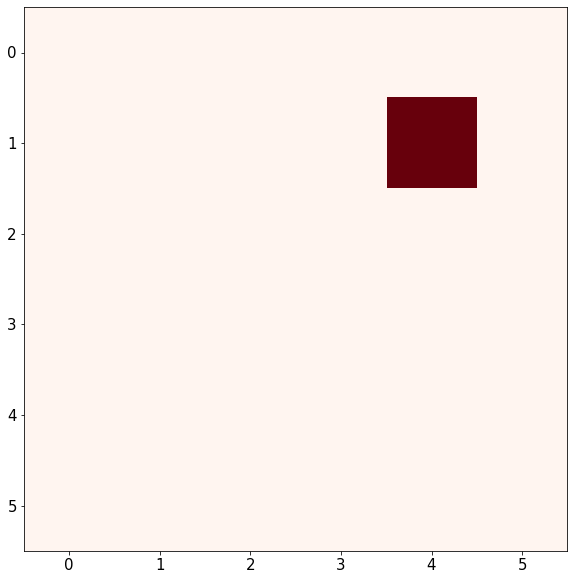

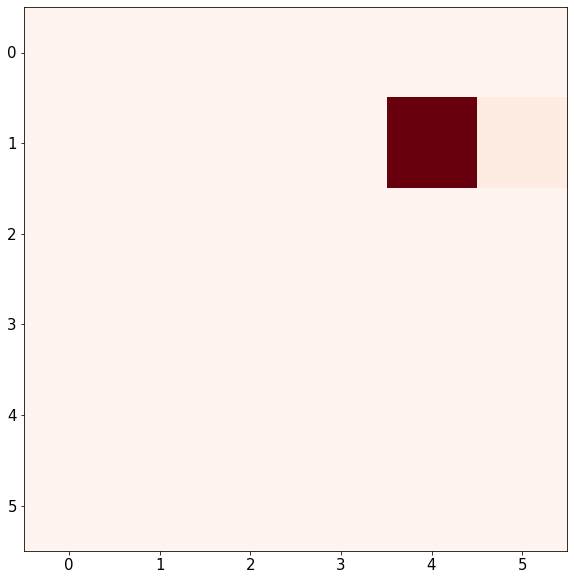

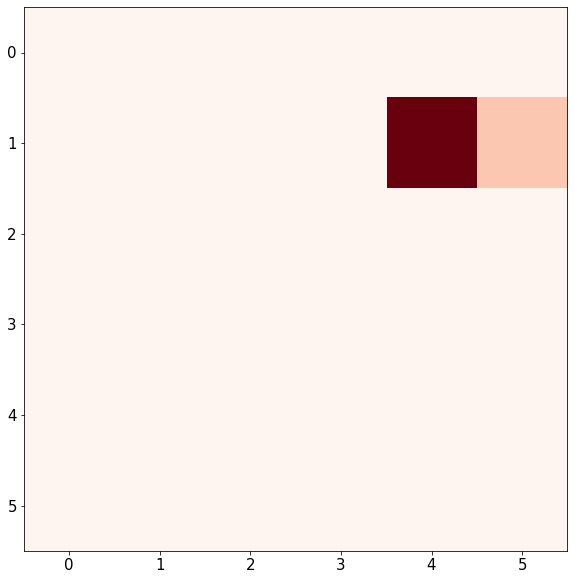

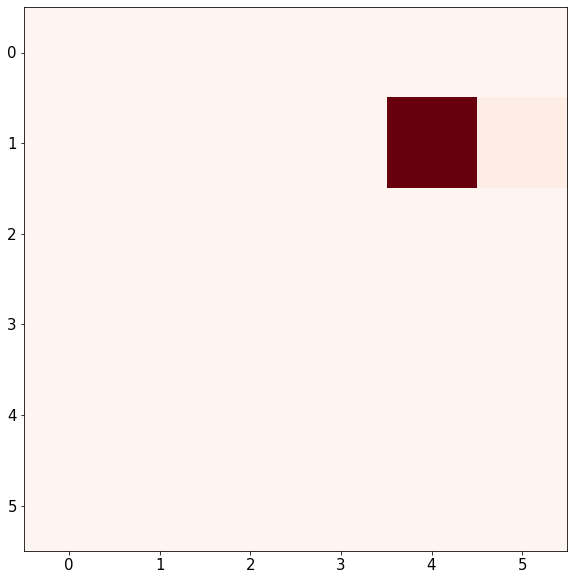

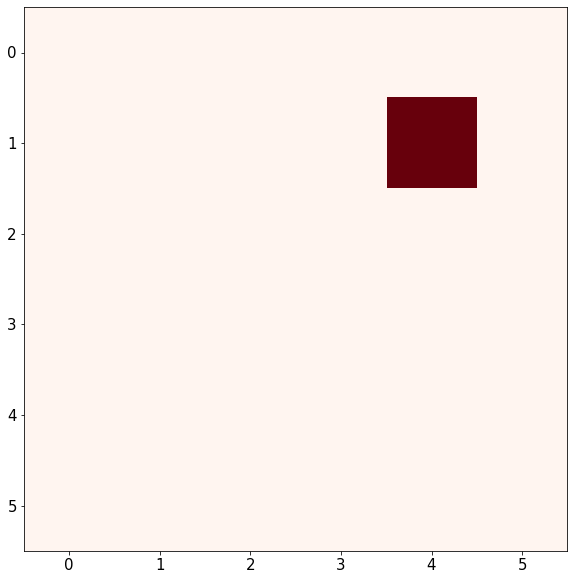

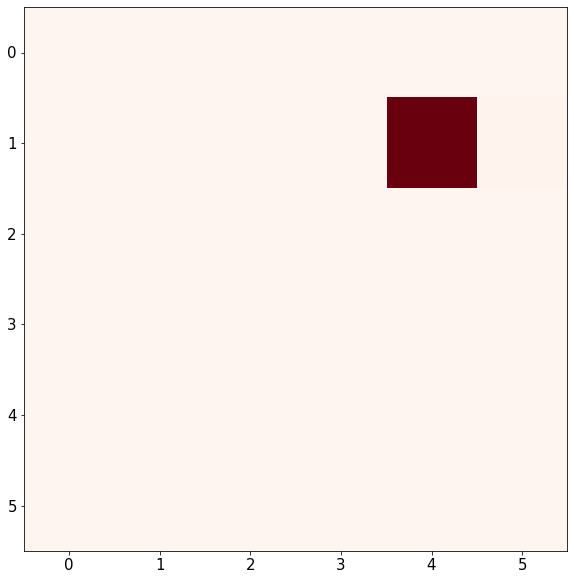

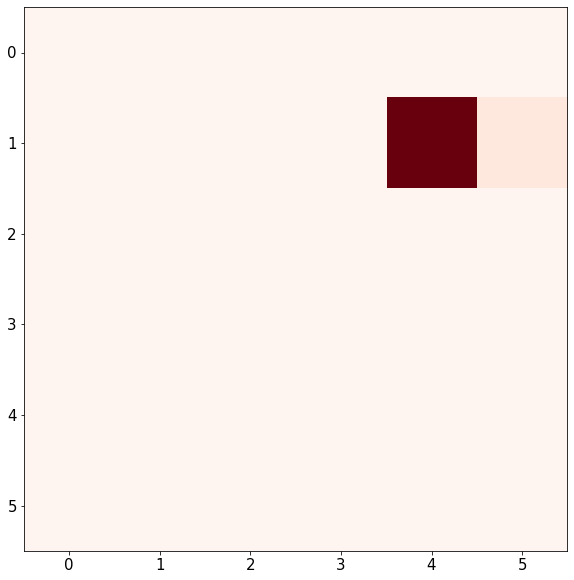

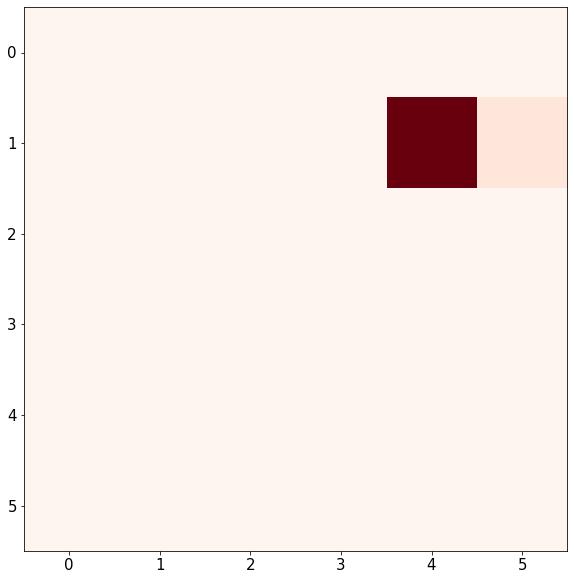

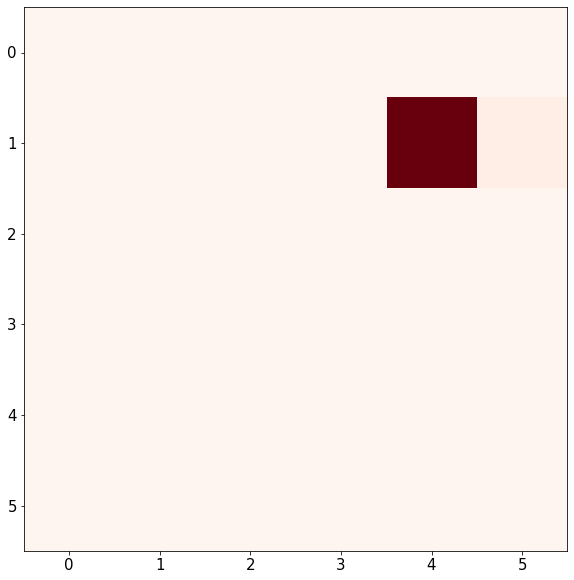

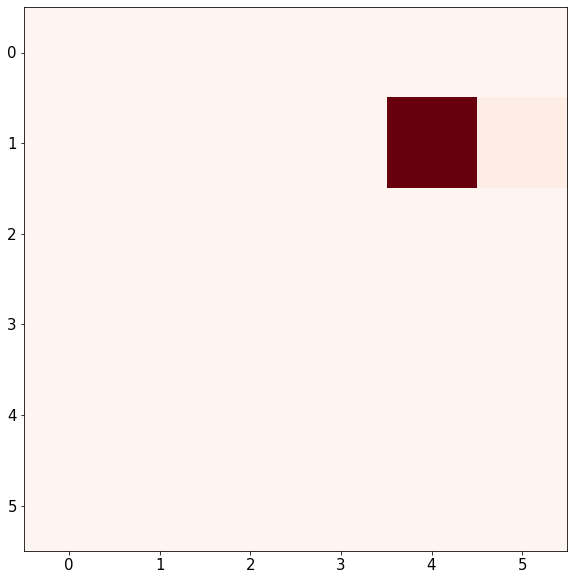

In [32]:
print(list(df_by_labels.keys()))

for a in df_by_labels["R1_work_at_computer"]:
    fig, ax = plt.subplots(1, 1)
#     target = df_by_labels["R1_bed_to_toilet"][3]
    target = a[0:500]
    ts, _ = toTimeSeries(target, 10000)
    ts = normalise(ts)
    ts = ts[40:]
#     print(len(ts))
    
    plotHeatMapv2(ax, ts, "", cmap="Reds")
    